<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

In [ ]:
#@title Run this to download the data and setup our environment
import cv2
import dlib
import gdown
import pickle
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

import urllib.request

from sklearn import metrics


from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

###Getting the csv data loaded
!wget -O ./ferdata.csv "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv"

###Getting the Dlib Shape predictor!
!wget -O ./shape_predictor_68_face_landmarks.dat "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat"

###Getting the Xpure loaded
!wget -O ./pureX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/pureX.npy"

###Getting the Xdata loaded
!wget -O ./dataX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataX_edited.npy"

###Getting the Ydata loaded
!wget -O ./dataY.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataY.npy"

print ("Data Downloaded!")


--2021-07-02 03:01:05--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.212.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167738172 (160M) [text/csv]
Saving to: ‘./ferdata.csv’

./ferdata.csv       100%[===================>] 159.97M   151MB/s    in 1.1s    

2021-07-02 03:01:06 (151 MB/s) - ‘./ferdata.csv’ saved [167738172/167738172]

--2021-07-02 03:01:06--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connectin

In this notebook we'll be:
1.   Understanding the Feature Generation Process
2.   Understanding, Visualizing, and Preparing the Data
3.   Applying Machine Learning to Emotion Detection



#Milestone 1: Understanding Feature Generation Process

## Instructor-led Discussion: Understanding the significance of Facial landmarks


Take a look at the images with facial landmarks superimposed over the faces!

![alt text](https://upload.wikimedia.org/wikipedia/commons/0/0a/Dlib-face_landmark_detection.jpg)

###Exercise 1A(Discussion) | Est Time: | Within a student group

#### Comment on positions of Facial Landmarks(FL) based on different emotion images? Can we used euclidean distance to distinguish between emotions?

##Distance between Facial Landmarks



Based on our discussion, we can use the euclidean distances of all facial landmarks with each other and use it as input (X) to our model to predict our emotions (Y)

###Exercise 1B (Discussion) | Est Time: | Within a student group

In [ ]:
#@title Q1: Number of distance values after computing euclidean distances among facial landmarks? Q2: Number of distance values after computing euclidean distances (exclusive of distances of facial landmarks points with itself and repeats)? { display-mode: "form" }

Q1 = "4624" #@param ["2278","4556","4624","68","Fill Me In"] 

Q2 = "2278" #@param ["2278","4556","4624","68","Fill Me In"] 

if Q1 == '4624': 
  print('Yes! 68 * 68 = 4624.') 
else: 
  print('Try Again')

if Q2 == "2278": 
  print("Thats Right! If we exclude the distance of points with itself and repeats, we will have 67+66+65+...+1 = 2278 distance values")
else: 
  print('Try again!')

Yes! 68 * 68 = 4624.
Thats Right! If we exclude the distance of points with itself and repeats, we will have 67+66+65+...+1 = 2278 distance values


In [ ]:
# one
def recursive_choosing(num):
  if num == 1:
    return 0
  return num - 1 + recursive_choosing(num-1)
print(recursive_choosing(68))

# two
# n = int(input("what number: "))
sum = 0
for i in range(68):
  sum+=i
print(sum)

#three
def choose(n, num):
  nFact = n
  numFact = num
  product = 1
  divisor = 1
  for i in range(num):
    product *= nFact
    nFact -= 1
  for i in range(num):
    divisor *= numFact
    numFact -= 1
  return product / divisor
print (choose(68,2))

2278
2278
2278.0


###Exercise Takeaways!



Facial landmark distances can be used as features (X) into a model where the outputs (Y) are emotions

## Instructor-led Discussion: Emotion Detection Pipeline

The three main components of Emotion Detection are as follows:


1.   Image Preprocessing
2.   Feature Extraction
3.   Feature Classification



# Milestone 2: Understand,Visualize and Prepare the Data

### Dataset Background

We will use modified version of the fer2013 dataset consisting of five emotion labels. 

The dataset is stored in a csvfile. Each row in the csvfile denotes an instance. 
Every instance has two column attributes : 

*   Pixels of the image stored in string format 
*   Integer encoding of the target label

There are total of 20,000 images distributed equally across the five emotions. The images are 48\*48 grayscale cropped images. The csvfile consists of flattened array of the image stored in form of a string

The target labels are integer encoded in the csvfile.They are mapped as follows:

*   0 ---> Angry
*   1 ---> Happy
*   2 ---> Sad
*   3 ---> Surprise
*   4 ---> Neutral



### Load the dataset 

In [ ]:
#Integer to Label Mapping
label_map = {0:"ANGRY",1:"HAPPY",2:"SAD",3:"SURPRISE",4:"NEUTRAL"}

#Load the datala
df = pd.read_csv("./ferdata.csv")
df.head()

,emotion,pixels,Usage
0,0,215 216 215 215 215 216 216 216 214 178 81 30 ...,Training
1,4,244 244 244 244 243 244 242 190 132 93 81 73 7...,Training
2,4,255 255 255 255 255 255 255 255 255 255 255 25...,Training
3,4,38 56 60 52 58 65 53 44 35 48 59 60 36 30 21 3...,Training
4,4,77 40 27 21 22 25 20 31 27 17 27 42 47 55 51 4...,Training


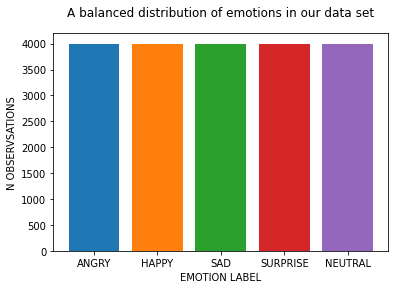

In [ ]:
# generate x labels for our plot
emotion_labels = [label_map[i] for i in label_map.keys()]

# generate counts for each emotion type
emotion_counts = [np.sum(df["emotion"] == i) for i in range(len(label_map))]

# generate a bar plot for our emotion labels that has different colors 
[plt.bar(x = emotion_labels[i], height = emotion_counts[i] ) for i in range(len(emotion_labels))] 

# make the plot interpretable with x and y labels + title
plt.xlabel('EMOTION LABEL')
plt.ylabel('N OBSERVSATIONS')
plt.title('A balanced distribution of emotions in our data set', y=1.05); 

###Exercise 2A Balanced vs. Unbalanced Datasets

####What would be the implications of an unbalanced dataset?

### Data Visualization

In this section, we will convert the flattened pixel arrays to 2D images, so as to plot facial landmarks over the images

In [ ]:
#@title Run this code to setup the extraction of Facial Landmarks

# Load's dlib's pretrained face detector model
#frontalface_detector = dlib.get_frontal_face_detector()


#Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):
  
  
  #:type image : cv2 object
  #:rtype landmarks : list of tuples where each tuple represents 
  #                  the x and y co-ordinates of facial keypoints
  
  #Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

  #Read Image using OpenCV
  #image = cv2.imread(image_path)
  #Detect the Faces within the image
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

"""
Display image with its Facial Landmarks
"""
def image_landmarks(image,face_landmarks):
  """
  :type image_path : str
  :type face_landmarks : list of tuples where each tuple represents 
                     the x and y co-ordinates of facial keypoints
  :rtype : None
  """
  radius = -2
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)
    
  plt.imshow(image_copy, interpolation='nearest', cmap='Greys_r')
  plt.xticks([]); plt.yticks([])
  plt.show()
  
 
'''
Converts pixels values to 2D-image. 
Displays the image and returns the cv2 image
object
'''
def pixels_image(img_pixels,plt_flag):
  """
  :type image_pixels : str
  :type plt_flag : boolean
  :rtype image : cv2 object
  """
  
  width = 48
  height = 48
  
  image = np.fromstring(img_pixels, dtype=np.uint8, sep=" ").reshape((height, width))
  
  if plt_flag:
      plt.imshow(image, interpolation='nearest', cmap="Greys_r")
      plt.xticks([]); plt.yticks([])
      plt.show()
      
      
  return image


###Lets visualize our datapoints!

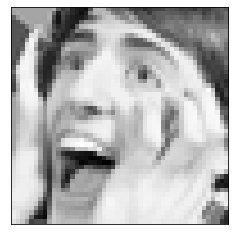

In [ ]:
# select random index 
i_index = np.random.randint(len(df))

# extract pixel values 
image_pixels = df['pixels'][i_index]        

# convert pixels to 2D Images
image = pixels_image(image_pixels, True)

In [ ]:
#@title Can you get the label for the face above? 

In [ ]:
print(df["emotion"][i_index])
#print(label_map[i_index])
print(label_map[df["emotion"][i_index]])

1
HAPPY


####Plot Facial Landmarks on the Datapoints

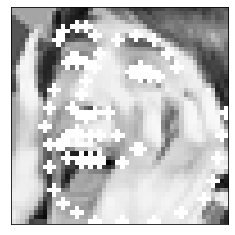

In [ ]:
#Extract the Facial Landmarks
image,facial_landmarks = get_landmarks(image)
#Display the Facial Landmarks on the Image
image_landmarks(image,facial_landmarks)

###Extract the features and save the data

 We'll need to create X and Y arrays for our model:
 
      X is a list of lists, where each element in X represents a single picture
                            where a picture is represented by a list distances 
                            between facial landmark points

      Y is a list of numbers, where each element in Y represents the emotion 
                              for the corresponding picture

      X_pixels is a list of lists, where each element in X represents a single 
                           picture where a picture is represented by its pixels 

 X and Y must be ordered in the same way so that X[0] and Y[0] refer to the 
 first picture, X[1] and Y[1] refer to the second picture, and so on.

 

###Euclidean Distance between Facial Landmarks

In this section we want to compute the euclidean distances between all 68 Facial Landmark points, excluding the distances of the points with themselves. 

We can get all the pairs of indices up to 4 using the `itertools` library. Try it out!

In [ ]:
for i, j in itertools.combinations(range(4), 2):
  print(i, j)
print()
for i, j, k in itertools.combinations(range(4), 3):
  print(i, j, k)

0 1
0 2
0 3
1 2
1 3
2 3

0 1 2
0 1 3
0 2 3
1 2 3


The 4 determines the number of indices, and the 2 says we're interested in combinations of size 2. (try changing 2 to three and see what happens if you're curious!). 

Notice how pairs with the same numbers are skipped (i.e. 0 0 is skipped) and that for each pair only one ordering of that pair is used (i.e. we have 0 2 but not 2 0)! 

####Exercise(Coding)

Use this special for loop to help us compute the euclidean distances for each pair of Facial Landmark points. Store all the distances in the list `e_dist`

Hint: Instead of having indicies that go up to 4, we want to have indices that go up to the number of facial landmarks we have!

In [ ]:
"""
Computes euclidean distance between 68 Landmark Points for our features
e_dist is a list of features that will go into our model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature. 
Scipy Library has readily available fuction to compute euclidean distance. You can 
compute the distance using distance.euclidean(point1,point2)
point1,point2 :2D points
"""
def landmarks_edist(face_landmarks):
  
    e_dist = []

    for i, j in itertools.combinations(range(68), 2):
      e_dist.append(distance.euclidean(face_landmarks[i], face_landmarks[j]))
   
    # FILL ME IN!
    # Use this to get the distance between two points: 
    #               distance.euclidean(face_landmarks[i],face_landmarks[j])
    return e_dist

In [ ]:
#@title Function that preprocesses the data to extract distances between all points

def preprocess_data(df):
  
  X = []
  Y = []
  X_pixels = []
  
  n_pixels = 2304
  
  for index, row in (df.iterrows()):

      if index%1000 == 0:
        print (index, "Datapoints Processed")
        
      try:
          image = pixels_image(row['pixels'],0)
          X_pixels.append(image.ravel()) 
          image = cv2.GaussianBlur(image,(5,5),0)
         
          _,face_landmarks = get_landmarks(image)
          X.append(landmarks_edist(face_landmarks)) # Using our feature function!
          Y.append(row['emotion'])

      except Exception as e:
          print ("An error occured:",e)

  #Save the data 
  np.save("pureX", X_pixels)
  np.save("dataX", X)
  np.save("dataY", Y)
  
  return np.array(X_pixels),np.array(X),np.array(Y) 

###Load the Saved Data

In [ ]:
# set to True if we want to preload data -- which has already been generated for us :) 
preload = True 

if preload: 

  # load outputs saved in this folder after running preprocess_data() 
  dataX = np.load('./dataX.npy')
  dataY = np.load('./dataY.npy', allow_pickle=True)
  
else: 
  
  # this takes 15-20 minutes to run, but someone has already run it and saved the ouputs in this folder
  pureX, dataX, dataY = preprocess_data(df)

###Split the data



We split our data into different 'sets' that each will work differently with our machine learning model.

Think of our AI as a machine learning 'student'.

**Training Set**: Our training set is like a training manual. Our algorithm will read, or 'train', on this over and over again to try and learn its task.

**Test Set**: Our test set is like a test. It is testing our model on problems that it has not seen before.

We usually have a much larger training manual than our test. Let's see if this is the case with our data!

In [ ]:
#Split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.1, random_state=42,stratify =dataY)

### Instructor-led Discussion: Standardization of Data

Standardization is the process of putting different variables on the same scale. It is a transformation that centers the data by removing the mean value of each feature and then scale it by dividing (non-constant) features by their standard deviation.

After standardizing data the mean will be zero and the standard deviation one.

We can use sklearn's inbuilt function which will help us to standardize our train data:
* `StandardScaler()`

In [ ]:
####Standardize the data####################
###Note: Do not use test data to fit your Standardscaler Model
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(18000, 2278)

### Instructor-led Discussion: Dimensionality Reduction

Dimensionality reduction helps us find a low-dimensional representation of the data that retains as much information as possible.

Principal Component Analysis (PCA) is one such technique.PCA is a technique used to emphasize variation and bring out strong patterns in a dataset. 



In [ ]:
#Reduces features by maintaining 95% variance of the data
#After doing PCA on our training data, 2278 Dimensions --->reduced to 20
#Note: PCA is trained only on training data 
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test= pca.transform(X_test)

In [ ]:
X_train.shape

(18000, 20)

#Milestone 3 : Applying Machine Learning to Emotion Detection

##Activity 3a. Defining our machine learning problem

Before we build our model, we have to identify what kind of problem it will solve and what data it's going to use. 

### Instructor-led Discussion: Machine Learning for Emotion Detection?


What WILL our model look like? Remember, in machine learning, we always identify inputs and outputs. Our goal is to predict outputs from inputs with either classification or regression.

In classification, our output is a category (like dogs or cats).

In regression, our output is a value (like 0, 0.1, 0.3, 100, ...).

In [ ]:
#@title How will our model operate? { display-mode: "form" }

#@markdown What are our inputs? 
inputs = "distances between facial landmarks" #@param ["images", "facial landmarks", "distances between facial landmarks", "Fill Me In"]

#@markdown What are our outputs? 
outputs = "integer encoded emotions" #@param ["integer encoded emotions", "images", "image edges", "Fill Me In"]

#@markdown What kind of problem will our AI model solve? 
problem_type  = "classification" #@param ["classification", "regression","Fill Me In"]


if inputs == "distances between facial landmarks":
  print("Yes, our inputs are our distance between facial landmarks!")
else:
  print('Not quite our inputs.')

if outputs == "integer encoded emotions":
  print("Yes, our outputs are integer encoded emotions!")
else:
  print('Not quite our outputs.')
  
if problem_type == "classification":
  print("We are trying to predict labels, therefore this is classification!")
else:
  print('Not quite our problem!')

Yes, our inputs are our distance between facial landmarks!
Yes, our outputs are integer encoded emotions!
We are trying to predict labels, therefore this is classification!


## Activity 3b. Building and evaluating models


We've tried a the KNN, Logistic Regression,Decision Tree model last week in sklearn. Establish best baseline acccuracy using either of the models today. Below, we list it with the sample parameters:
* `knn = KNeighborsClassifier(n_neighbors = 1)`
* `lr = LogisticRegression(solver='lbfgs',multi_class='multinomial')`
* `dt = DecisionTreeClassifier(max_depth=1)`




Test your models with accuracy_score on the test_data, which can be accessed through the X_test variable

Try to build the best model that you can! 

Human accuracy for the fer2013 dataset is 65% +- 5%. Lets try getting as closer as possible!



### Exercise (Coding)     | Est Time | Within a student group


###Train the model

In [ ]:
### YOUR CODE BELOW
### USE AS MANY CELLS AS YOU WANT!
### NAME YOUR MODEL as knn

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

0.4615
0.503
0.307


###Evaluate the model

In [ ]:
### YOUR CODE BELOW
### USE AS MANY CELLS AS YOU WANT!
### PREDICT TEST LABELS AND SAVE THEM AS y_pred

###Exercise 3A(Discussion) | Est Time: | Within a student group

Discussion over different algorithms used for Emotion Detection!



###Plot the Confusion Matrix

In [ ]:
'''
Plots the confusion Matrix and saves it
Pass the true labels and the predicted labels
'''
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  #plt.savefig(fig_name)
  plt.show()
  plt.close()

Plotting the Confusion Matrix


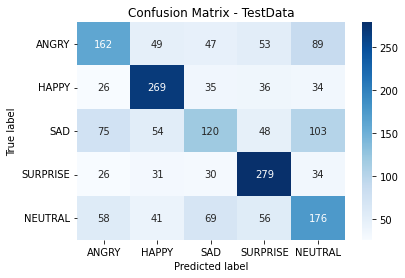

In [ ]:
plot_confusion_matrix(y_test,y_pred)

####Exercise (Discussion) | Est Time: | Within a student group

In [ ]:
#@title Take a look at your confusion Matrix and answer the following questions

#@markdown Name most correctly classified emotion? 
correct_emotion = "Surprise"#@param ["Anger","Happy","Sad","Surprise", "Neutral","Fill Me In"] 

#@markdown Name most incorrectly classified emotion? 
incorrect_emotion = "Sad"#@param ["Anger","Happy","Sad","Surprise", "Neutral","Fill Me In"] 

#@markdown Sad Emotion is highly misclassified as?
sad_misclassify ="Neutral"#@param ["Anger","Happy","Sad","Surprise", "Neutral","Fill Me In"] 

#@markdown Neutral Emotion is highly misclassified as?
neutral_misclassify ="Sad"#@param ["Anger","Happy","Sad","Surprise", "Neutral","Fill Me In"] 


#@markdown Angry Emotion is highly misclassified as?
angry_misclassify ="Neutral"#@param ["Anger","Happy","Sad","Surprise", "Neutral","Fill Me In"] 



#Milestone 4: Coding Exercise



We performed feature generation and extraction process in the previous sections. Now train your best model from Section 3 again with actual pixels of the images with standardization.

####Report and Comment over the result!

In [ ]:
#Load the true pixel data and corresponding labels
X = np.load('pureX.npy')
Y = np.load('dataY.npy')

In [ ]:
###YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42,stratify =Y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test= pca.transform(X_test)

lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

0.404


#Finish!

### Example

In [ ]:
# extract images as vectors, convert from strings to ints -- this is called a "list comprehension" 
x_image = np.array( [np.fromstring(df['pixels'][i], dtype=np.uint8, sep=" ") for i in range(len(df))] ) 

# extract labels in the same way--through a list comprehension
y_image = np.array( [df['emotion'][i] for i in range(len(df)) ])

# generate train-test (90/10) splits
X_train, X_test, y_train, y_test = train_test_split(x_image, y_image, test_size=0.1,random_state=42)

# define the model
knn = KNeighborsClassifier(n_neighbors=10)

# train 
print ("training knn model ...")
knn.fit(X_train, y_train)

# test
print ("Predict for KNN Model")
y_pred_knn = knn.predict(X_test)

# display results
print ("KNN Test Accuracy on raw image inputs:", metrics.accuracy_score(y_test, y_pred_knn))

training knn model ...
Predict for KNN Model
KNN Test Accuracy on raw image inputs: 0.359
